In [1]:
import math
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple

In [2]:
SEED = 42

def set_seed(seed=SEED):
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [3]:
from lunar_lander import LunarLander
# base_env = LunarLander()
env = LunarLander(enable_wind=False)
test_env = LunarLander(enable_wind=False)
# Fixing RNG for env
env.reset(seed=SEED)
test_env.reset(seed=SEED)

(array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
        -0.05269805,  0.        ,  0.        ], dtype=float32),
 {})

In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BUFFER_SIZE = 100000  # Replay memory size
BATCH_SIZE = 64       # Minibatch size
GAMMA = 0.99          # Discount factor
TAU = 1e-3            # Soft update of target parameters
LR = 5e-4             # Learning rate
UPDATE_EVERY = 5      # How often to update the network
N_EPOCHS = 5      
# Training parameters
n_episodes = 3000
max_t = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
recurrent = True

Using device: cuda


In [5]:
from agent import Agent
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
agent = Agent(state_size=state_shape, action_size=action_shape, device=device,
        recurrent=recurrent, lr=LR, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA,
        tau=TAU, update_every=UPDATE_EVERY, n_epochs=N_EPOCHS)

Initializing Recurrent DQN Agent (LSTM)...
RecurrentDeepQNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc_out): Linear(in_features=64, out_features=4, bias=True)
)


In [6]:
scores = []                        # list containing scores from each episode
eval_scores = []
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon

print("Training started...")
for i_episode in range(1, n_episodes+1):
    state, _ = env.reset()
    hidden = agent.qnetwork_local.init_hidden(1)
    score = 0
    for t in range(max_t):
        action, next_hidden = agent.act(state, eps, hidden)
        next_state, reward, done, truncated, _ = env.step(action)
        
        agent.step(state, action, reward, next_state, done or truncated, hidden, next_hidden)
        
        state = next_state
        hidden = next_hidden
        score += reward
        
        if done or truncated:
            break
            
    scores_window.append(score)       # save most recent score
    scores.append(np.mean(scores_window))              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon

    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f} \tEpsilon: {eps:.3f}', end="")
    
    if i_episode % 10 == 0:
        # Evaluation every 100 episodes
        eval_score_list = []
        for _ in range(5):  # run 5 evaluation episodes
            state, _ = test_env.reset()
            hidden = agent.qnetwork_local.init_hidden(1)
            eval_score = 0
            for t in range(max_t):
                action, next_hidden = agent.act(state, eps=0.0, hidden=hidden)  # no exploration
                next_state, reward, done, truncated, _ = test_env.step(action)
                state = next_state
                hidden = next_hidden
                eval_score += reward
                if done or truncated:
                    break
            eval_score_list.append(eval_score)
        eval_scores.append(np.mean(eval_score_list))
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        print(f'   Evaluation Score (avg over 5 episodes): {np.mean(eval_score_list):.2f}')

Training started...
Episode 100	Average Score: -134.40 	Epsilon: 0.606
   Evaluation Score (avg over 5 episodes): -295.86
Episode 200	Average Score: -68.38 	Epsilon: 0.3676
   Evaluation Score (avg over 5 episodes): -1.37
Episode 300	Average Score: 33.23 	Epsilon: 0.2228
   Evaluation Score (avg over 5 episodes): 192.82
Episode 400	Average Score: 158.19 	Epsilon: 0.135
   Evaluation Score (avg over 5 episodes): 229.87
Episode 500	Average Score: 204.20 	Epsilon: 0.082
   Evaluation Score (avg over 5 episodes): 229.70
Episode 501	Average Score: 204.65 	Epsilon: 0.081

KeyboardInterrupt: 

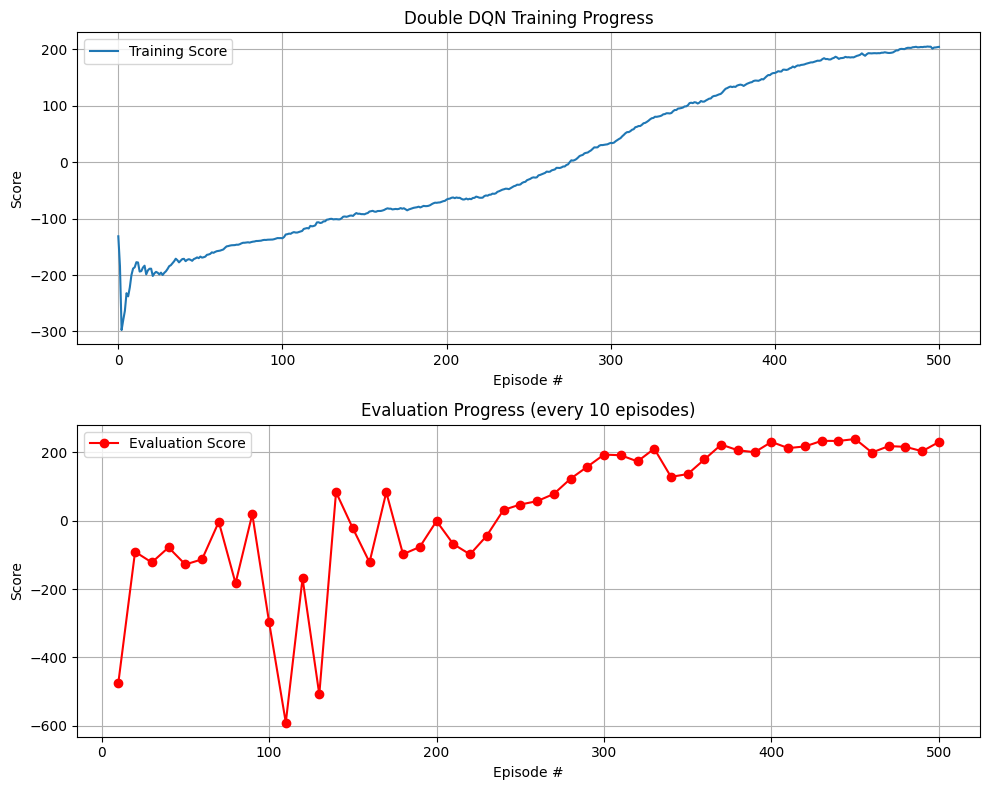

In [7]:
# Plot training and evaluation scores
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Training scores
ax1.plot(np.arange(len(scores)), scores, label='Training Score')
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('Double DQN Training Progress')
ax1.legend()
ax1.grid(True)

# Evaluation scores
ax2.plot(np.arange(len(eval_scores))*10 + 10, eval_scores, 'r-o', label='Evaluation Score')
ax2.set_ylabel('Score')
ax2.set_xlabel('Episode #')
ax2.set_title('Evaluation Progress (every 10 episodes)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# test_env.MAIN_ENGINE_POWER = 6.5 -> (1.0, 30.0)
# test_env.SIDE_ENGINE_POWER = 1.2

def evaluate_robustness_averaged(agent, env, base_unit=11.0, max_unit=15.0, steps=40, runs_per_point=5):
    """
    Sweeps pole lengths from base_length to max_length.
    Runs 'runs_per_point' episodes for each length.
    Returns means and standard deviations.
    """
    units = np.linspace(base_unit, max_unit, steps)
    means = []
    stds = []
    
    print(f"--- Starting Robustness Sweep ({runs_per_point} runs per point) ---")
    
    for l in units:
        episode_rewards = []
        
        for run in range(runs_per_point):
            env.MAIN_ENGINE_POWER = l
            env.scale = 2.0
            
            # 2. Run Episode
            obs, _ = env.reset()
            total_reward = 0
            terminated = False
            truncated = False

            for t in range(max_t):
                action = agent.act(obs, eps=0.0)
                obs, r, terminated, truncated, _ = env.step(action)
                total_reward += r
                if (terminated or truncated): break
            
            episode_rewards.append(total_reward)
            env.close()
        
        # 3. Stats
        avg = np.mean(episode_rewards)
        std = np.std(episode_rewards)
        means.append(avg)
        stds.append(std)
        print(f"Main Power {l:.2f}: Mean Reward = {avg:.1f} +/- {std:.1f}")

    return units, np.array(means), np.array(stds)

# --- RUN IT ---
# Assuming 'model' is your trained DQN
# If you don't have the model loaded yet, comment out the agent line to test with random actions
lengths, means, stds = evaluate_robustness_averaged(agent, test_env)

# --- PLOT RESULTS ---
plt.figure(figsize=(10, 6))
plt.plot(lengths, means, label="Mean Reward", color="blue")
plt.fill_between(lengths, means - stds, means + stds, color="blue", alpha=0.2, label="Variance (Std Dev)")

# plt.axvline(x=0.5, color='green', linestyle='--', label="Training Env (Length=0.5)")
# plt.axvline(x=1.0, color='red', linestyle='--', label="Test Env (Length=1.0)")

plt.title("DQN Robustness: Zero-Shot Transfer Performance")
plt.xlabel("Pole Length (Meters)")
plt.ylabel("Average Reward (5 Runs)")
plt.legend()
plt.grid(True)
plt.show()